# O2 flux

##### RUN:
/data/tjarniko/results/j13r
##### DATE:  Jan13_2019
##### description of point: 

calculate intermediate calculations for oxygen flux. check units/check that numbers make sense with literature



# 1) Air-sea flux in SOG

### in SOG - in air_sea_fluxes.f90

gas flux = (transfer vel) * solubility* (difference in p_gas - p_air) 

    ! Transfer velocity, Nightingale et al. 2000
    kps = (0.22d0 * UU**2 + 0.33d0 * UU) * (sc/600.0d0)**(-0.5d0)
    kps = kps * 2.778d-6   ! m/s

    ! Gas flux
    ! (m/s * mol/m^3atm * (1e3 mmol/mol) * atm = mmol m-2 s-1)
    gasflux = kps * sol * 1.0d3 * (1.0d-6 * p_gas - p_air)

    gasflux = kps * sol * 1.0d3 * (1.0d-6 * p_gas - p_air)


###### NB/?:
    Is there a problem here with brackets? shouldn't there be a bracket around p_gas - p_air? If not, why is p_gas being converted to umol?



### in SKOG - in p4zflx.f90

### flux down

        zfld16 = [apr(ji,jj) * 1./101325.] * [chemo2(ji,jj)] * [tmask(ji,jj,1)] * [zkgo2(ji,jj)]  ! (mol/L) * (m/s)

                [atm] * [(mol/(L atm))] * [boolean] * m^2/s^2 (?)

       getting: mol/L * m^2/s^ 2          

### flux up
                zflu16 = trb(ji,jj,1,jpo2) * tmask(ji,jj,1) * zkgo2(ji,jj)

                mmol/m^3 *[boolean] * m^2/s^2 (?)


                #umol L^-1 is what our model is in
                QQ - problem in conversion to mmol/m3?
                (https://www.oceanbestpractices.net/bitstream/handle/11329/417/56281.pdf?sequence=1&isAllowed=y)
                mmol/m^3 is ~ umol/L


### addition of the two

         tra(ji,jj,1,jpo2) = tra(ji,jj,1,jpo2) + (zoflx(ji,jj) * rfact2 / fse3t(ji,jj,1))*        

                                [ mmol/m^3 ]     + [mol/L*(m/s)] * [(s)] / [(m^3 ???)]


               hmmmmmm

               definitely need to convert mol/L to umol/L, but that's easy; how to reconcile * units with jpo2?
               
               
### gas exchange coefficient

          zws  = wndm(ji,jj) * wndm(ji,jj) (m^2 s^-2)
            ! Compute the piston velocity for O2 and CO2
            zkgwan = 0.251 * zws
            zkgwan = zkgwan * xconv * ( 1.- fr_i(ji,jj) ) * tmask(ji,jj,1)
        # if defined key_degrad
            zkgwan = zkgwan * facvol(ji,jj,1)
        #endif
            ! compute gas exchange for CO2 and O2
            zkgco2(ji,jj) = zkgwan * SQRT( 660./ zsch_co2 )
            zkgo2 (ji,jj) = zkgwan * SQRT( 660./ zsch_o2 ) 
            
            should still be (m^2 s^-2)
            
### chemo2 - 

                      [dimensionless?] *  [mol/atm?] [/L??] *  [atm]
       chemo2(ji,jj) = [( EXP( zoxy ) * o2atm )] * [oxyco] * [atcox]
       REAL(wp), PUBLIC ::   atcox  = 0.20946         ! units atm
       REAL(wp) ::   o2atm  = 1. / ( 1000. * 0.20946 )
       !                                    ! volumetric solubility constants for o2 in ml/L
        
        REAL(wp) ::   oxyco  = 1. / 22.4144   ! converts from liters of an ideal gas 
       
       These constants come from Garcia and Gordon, 1992, but cm^3 / dm^3 column...
        
        REAL(wp) ::   ox0    =  2.00856      ! from Table 1 for Eq 8 of Garcia and Gordon, 1992.
       REAL(wp) ::   ox1    =  3.22400      ! corrects for moisture and fugacity, but not total atmospheric pressure
       REAL(wp) ::   ox2    =  3.99063      !      Original PISCES code noted this was a solubility, but
       REAL(wp) ::   ox3    =  4.80299      ! was in fact a bunsen coefficient with units L-O2/(Lsw atm-O2)
       REAL(wp) ::   ox4    =  9.78188e-1   ! Hence, need to divide EXP( zoxy ) by 1000, ml-O2 => L-O2
       REAL(wp) ::   ox5    =  1.71069      ! and atcox = 0.20946 to add the 1/atm dimension.
       REAL(wp) ::   ox6    = -6.24097e-3
       REAL(wp) ::   ox7    = -6.93498e-3
       REAL(wp) ::   ox8    = -6.90358e-3
       REAL(wp) ::   ox9    = -4.29155e-3
       REAL(wp) ::   ox10   = -3.11680e-7  
            
            
##### QQ:
    -why is chemo2 (mol/(L atm)? and do I trust that it actually is?
    -zkgo2 is gas exchange - is it m/s or m^2/s^2? and what makes physical sense? SOG has it as m/s, the gas exchange eq dimensions would suggest m^2/s^2
    -gas transfer coeff uses diff. eq. in SOG vs SKOG

In [24]:
## gas transfer back-of-env

# SOG
#    ! Transfer velocity, Nightingale et al. 2000
#    kps = (0.22d0 * UU**2 + 0.33d0 * UU) * (sc/600.0d0)**(-0.5d0)
#    kps = kps * 2.778d-6   ! m/s
print('gas transfer back-of-env - using SOG code')
U = 5 #m/s
ztc = 10
sc_o2  = 1920.4 - 135.6  * ztc + 5.2122 * ztc**2 - 0.109390 * ztc**3 + 0.0009377 * ztc**4
print('schmidt no oxy')
print(sc_o2)
print('gas transfer coeff')
kps = (0.22*U**2+.33*U)*(sc_o2/600)**(-0.5) *2.778*10**-6
print(kps)
print('Ord. mag. agrees with output mapped below!')

gas transfer back-of-env - using SOG code
schmidt no oxy
985.6070000000001
gas transfer coeff
1.549751333620615e-05
Ord. mag. agrees with output mapped below!


In [25]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [26]:
#import all the things

%reset
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import cmocean as cm
from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools)
import xarray as xr 
import subprocess 
import cmocean
from matplotlib import reload
import glob
import netCDF4 as nc
import VIZ_plots as VP

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Oxygen is exchanged with the atmosphere using the parameterization
of Wanninkhof (1992) to compute the gas exchange
coefficient. The atmospheric concentration of oxygen
is constant over time and space and cannot be specified by
the user. As for CO2, no air–sea fluxes are allowed when the
ocean is covered by sea ice (see Eq. 82).

In [27]:
reload(VP)

<module 'VIZ_plots' from '/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ/VIZ_plots.py'>

#### Available functions from VP

    two_panel_plot(surfdat_1,surfdat_2,tit1,tit2,t_cmap,xsize,ysize,vmin,vmax,clabel,bigtit)
    animate_surf(hrly_dat,tit,v_min,v_max,t_cmap)

In [28]:
resdir = '/data/tjarniko/results/j13r/'
ptrc = 'SalishSea_1ts_20171026_20171026_ptrc_T.nc'
#tgrid = 

tracers = nc.Dataset(resdir + ptrc)
print(tracers)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SalishSea_1ts_20171026_20171026
    description: biogeochemical variables
    title: biogeochemical variables
    Conventions: CF-1.6
    timeStamp: 2019-Jan-14 05:36:59 GMT
    uuid: 601b9e8f-cbd5-4488-a5db-f9cf47bfa250
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(3)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_lon(y,x,nvertex), float32 bounds_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 nitrate(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 ammonium(time_counter,deptht,y,x), float32 silicon(time_counter,deptht,y,x), float32 diatoms(time_counter,deptht,y,x), float32 

chemo2
0.000235424
0.000358105
zkgo2
0.0
4.86367e-05
patm
1.0050707809
1.0094251172
oce_o2
0.0
0.00107593


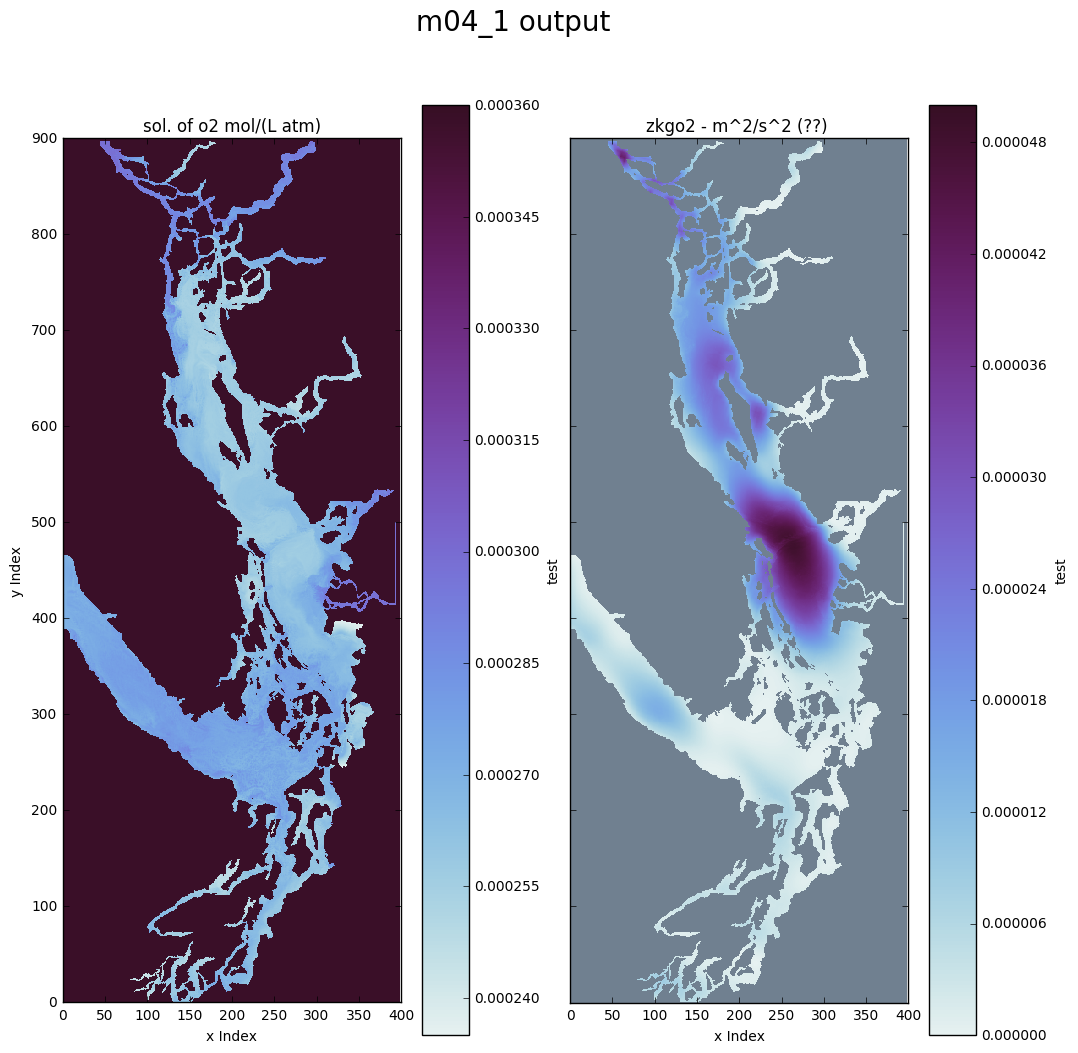

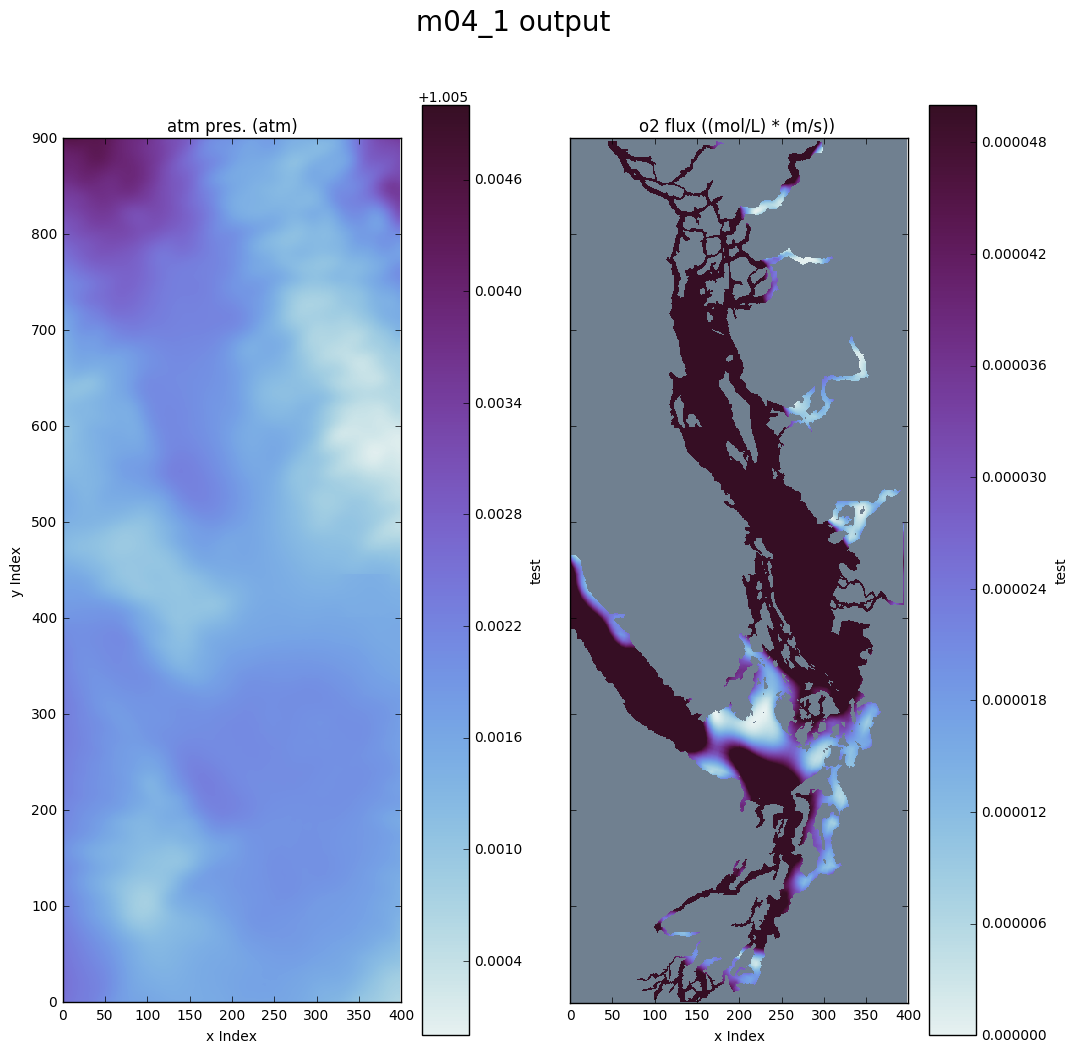

In [29]:
chemo2 = tracers.variables['of_chemo2'][0,:,:]
zkgo2 = tracers.variables['of_zkgo2'][0,:,:]
patm = tracers.variables['of_patm'][0,:,:]
patm = patm/101325
oce_o2 = tracers.variables['oce_o2'][0,:,:]

print('chemo2')
print(np.min(chemo2))
print(np.max(chemo2))
print('zkgo2')
print(np.min(zkgo2))
print(np.max(zkgo2))
print('patm')
print(np.min(patm))
print(np.max(patm))
print('oce_o2')
print(np.min(oce_o2))
print(np.max(oce_o2))


# mmin = 600
# mmax = 2250
VP.two_panel_plot(chemo2,zkgo2,'sol. of o2 mol/(L atm)','zkgo2 - m^2/s^2 (??) ',cm.cm.dense,12,12,0.000235,0.00036,0,5e-05,'test','test','m04_1 output')

VP.two_panel_plot(patm,oce_o2,'atm pres. (atm)','o2 flux ((mol/L) * (m/s)) ',cm.cm.dense,12,12,1.005,1.01,0,5e-05,'test','test','m04_1 output')


#VP.two_panel_plot(O2_surf,CO2f_surf,'o2 surf','co2flx surf',cm.cm.dense,12,12,0,10,0,0.00004,'test','m04_1 output')

## note the o2 is from the old init conditions, which were in ml/L, would need conv to umol/L


In [30]:
o2 = tracers.variables['dissolved_oxygen']

# conv from mL/L to umol/L is * 44.6596
print(o2)
print(o2[0,0,250,250])

<class 'netCDF4._netCDF4.Variable'>
float32 dissolved_oxygen(time_counter, deptht, y, x)
    standard_name: dissolved_oxygen_expressed_as_mole_equivalent
    long_name: Dissolved Oxygen Concentration
    units: mmol m-3
    online_operation: average
    interval_operation: 40 s
    interval_write: 40 s
    cell_methods: time: mean
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered deptht nav_lat nav_lon
unlimited dimensions: time_counter
current shape = (3, 40, 898, 398)
filling on
4.82043


# code check p4zflx

       ! FIRST COMPUTE GAS EXCHANGE COEFFICIENTS
              ! -------------------------------------------

        !CDIR NOVERRCHK
              DO jj = 1, jpj
        !CDIR NOVERRCHK
                 DO ji = 1, jpi
                    ztc  = MIN( 35., tsn(ji,jj,1,jp_tem) )
                    ztc2 = ztc * ztc
                    ztc3 = ztc * ztc2
                    ztc4 = ztc2 * ztc2
        !~~~~~~~~~~~~~walrus F_B compute schmidt number~~~~~~~~~~~~~~~~~~
                   ! Compute the schmidt Number for  O2
                    zsch_o2  = 1920.4 - 135.6  * ztc + 5.2122 * ztc2 - 0.109390 * ztc3 + 0.0009377 * ztc4
        !~~~~~~~~~~~~~walrus F_C compute piston velocity~~~~~~~~~~~~~~~~~
                    !  wind speed
                   zws = wndm(ji,jj) * wndm(ji, jj)

                   ! Compute the piston velocity for O2
                    zkgwan = 0.251 * zws
                    zkgwan = zkgwan * xconv * tmask(ji,jj,1)
         # if defined key_degrad
        ! not sure what this is
                    zkgwan = zkgwan * facvol(ji,jj,1)
        #endif
                   ! compute gas exchange for CO2 and O2
                   zkgo2 (ji,jj) = zkgwan * SQRT( 660./ zsch_o2 )
                 END DO
              END DO

        ! compute chemo2, solubility of o2 in mol/(L atm)

        !CDIR NOVERRCHK
                 DO jj = 1, jpj
        !CDIR NOVERRCHK
                    DO ji = 1, jpi
                      ztkel = tsn(ji,jj,1,jp_tem) + 273.15
                      zsal  = tsn(ji,jj,1,jp_sal) + ( 1.- tmask(ji,jj,1) ) * 35.
                      zsal2 = zsal * zsal
                      ztgg  = LOG( ( 298.15 - tsn(ji,jj,1,jp_tem) ) / ztkel )  ! Set the GORDON & GARCIA scaled temperature
                      ztgg2 = ztgg  * ztgg
                      ztgg3 = ztgg2 * ztgg
                      ztgg4 = ztgg3 * ztgg
                      ztgg5 = ztgg4 * ztgg
                      zoxy  = ox0 + ox1 * ztgg + ox2 * ztgg2 + ox3 * ztgg3 + ox4 * ztgg4 + ox5 * ztgg5   &
                             + zsal * ( ox6 + ox7 * ztgg + ox8 * ztgg2 + ox9 * ztgg3 ) +  ox10 * zsal2
                      chemo2(ji,jj) = ( EXP( zoxy ) * o2atm ) * oxyco * atcox     ! mol/(L atm)
                    END DO
                  END DO

              DO jj = 1, jpj
                 DO ji = 1, jpi

                    ! Compute O2 flux, convert apr from newtons to atmospheres
                    zfld16 = apr(ji,jj) * 1./101325. * chemo2(ji,jj) * tmask(ji,jj,1) * zkgo2(ji,jj)          ! (mol/L) * (m/s)
                    zflu16 = trb(ji,jj,1,jpo2) * tmask(ji,jj,1) * zkgo2(ji,jj)
                   zoflx(ji,jj) = zfld16 - zflu16
                   ! walrus original code - need rfact2 (== biocemistry timestep length) and fse3t, whatever that is
                   tra(ji,jj,1,jpo2) = tra(ji,jj,1,jpo2) + zoflx(ji,jj) * rfact2 / fse3t(ji,jj,1)
                 END DO
              END DO
        !~~~~~~~~~~~

           CALL iom_put("oce_o2", zoflx)

           CALL iom_put("of_patm",apr)
           CALL iom_put("of_chemo2",chemo2)

           CALL iom_put("of_zkgo2",zkgo2)
           CALL iom_put("f_co2flux",f_co2flux)
           CALL iom_put("f_dpco2",f_dpco2)


           CALL wrk_dealloc( jpi, jpj, zkgo2, chemo2, zoflx )

           IF( nn_timing == 1 )  CALL timing_stop('p4z_flx')

           END SUBROUTINE p4z_flx